# ***Model Implementation and Sentiment Analysis***

### By: Mayuresh Dongare || Adarsh Mahor || Marshall Pauley

## Questions to Tackle with Dataset:
1. **Can we predict the memory size of a GPU based on its clock speed and other specifications?**
2. **What are the major factors that determine the GPU clock speed?**
3. **Which authors generate the most engaging content in terms of scores and comments?**
4. **How well can we classify GPUs based on their performance into categories such as low, medium, and high performance?**
5. **Can we predict the release year of a GPU based on its technical specifications?**
6. **How do the specifications of GPUs vary by manufacturer?**
7. **Can machine learning models identify trends in GPU development over the years (e.g., increasing clock speeds or memory sizes)?**
8. **Principle Component Analysis on Numerical attributes.**
9. **Does the time of day or day of the week when a post is made affect its visibility and engagement level?**
10. **Discovering common topics or themes within the Submission Text or Comment Body using NLP techniques such as Latent Dirichlet Allocation (LDA) or Non-negative Matrix Factorization (NMF).**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
from datetime import datetime

In [2]:
file_post ='/Users/mayureshdongare/Desktop/CU Docs/Data Mining CSCI 5502/Data Mining Project/post_data.csv'
file_comment ='/Users/mayureshdongare/Desktop/CU Docs/Data Mining CSCI 5502/Data Mining Project/comment_data.csv'

df_post = pd.read_csv(file_post)
df_comment =pd.read_csv(file_comment)

In [3]:
df_post.head()

,Submission ID,Post Title,Post URL,Author,Score,Number of Comments,Upvote Ratio,Submission Text,Product Name,Product Category,Posting Time
0,17synze,Is Ryzen 7 7800x3D really that good?,https://www.reddit.com/r/LinusTechTips/comment...,ro3rr,39,85,0.76,"I have seen that a higher cache, such as x3d, ...",AMD Ryzen 7 7800X3D,Processor,2023-11-11 17:01:47
1,18f5j13,Ryzen 7 7800X3D is the GOAT,https://www.reddit.com/r/Amd/comments/18f5j13/...,Mopar_63,530,267,0.91,I do not know what voodoo AMD did with this ch...,AMD Ryzen 7 7800X3D,Processor,2023-12-10 15:05:59
2,12clszu,AMD Ryzen 7 7800X3D review megathread,https://www.reddit.com/r/buildapc/comments/12c...,inversion_modz,471,325,0.97,Hello everybody! \n\n &nbsp; \n\nThe AMD Ry...,AMD Ryzen 7 7800X3D,Processor,2023-04-05 14:16:04
3,18ogzwt,AMD Ryzen 7 7800X3D vs. Intel Core i9-14900K,https://www.techspot.com/review/2783-ryzen-780...,Stiven_Crysis,383,339,0.95,NaN,AMD Ryzen 7 7800X3D,Processor,2023-12-22 15:06:53
4,13kdel9,Ryzen 7 7800X3D is it worth the risk???,https://www.reddit.com/r/Amd/comments/13kdel9/...,Alarmed-Bad7994,17,66,0.69,Hello!!! I am in the processing of building a ...,AMD Ryzen 7 7800X3D,Processor,2023-05-17 20:39:53


In [4]:
df_comment.head()

,Comment ID,Parent ID,Comment Body,Author,Score,Product Name,Product Category,Posting Time
0,k8t258c,t3_17synze,> I have also read a blog from UserBenchmark\n...,bloodem,153,AMD Ryzen 7 7800X3D,Processor,2023-11-11 17:01:47
1,k8t248o,t3_17synze,Do not use userbenchmark it's trash and he hat...,aggressiveturdbuckle,248,AMD Ryzen 7 7800X3D,Processor,2023-11-11 17:01:47
2,k8t45x2,t3_17synze,userbenchmark is not to be trusted for their o...,Izan_TM,125,AMD Ryzen 7 7800X3D,Processor,2023-11-11 17:01:47
3,k8t98ke,t3_17synze,The person running userbenchmark seems to have...,KrisKorona,46,AMD Ryzen 7 7800X3D,Processor,2023-11-11 17:01:47
4,k8t7gd8,t3_17synze,Userbenchmark used to have fairly balanced rev...,ManyPandas,24,AMD Ryzen 7 7800X3D,Processor,2023-11-11 17:01:47


In [5]:
import re
from textblob import TextBlob

In [6]:
# List of curse words to filter out, add more as needed
curse_words = ['Fuck', 'fucking']  # Add more words as needed

def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)  # Remove non-letter characters
    text = text.lower()  # Convert to lowercase
    text = text.strip()  # Remove leading and trailing whitespace
    # Remove curse words, case insensitive
    for curse in curse_words:
        text = re.sub(r'\b{}\b'.format(curse), '', text, flags=re.IGNORECASE)
    return text

# Clean the comments
df_comment['Cleaned Comment Body'] = df_comment['Comment Body'].apply(clean_text)

In [7]:
df_comment.head()

,Comment ID,Parent ID,Comment Body,Author,Score,Product Name,Product Category,Posting Time,Cleaned Comment Body
0,k8t258c,t3_17synze,> I have also read a blog from UserBenchmark\n...,bloodem,153,AMD Ryzen 7 7800X3D,Processor,2023-11-11 17:01:47,i have also read a blog from userbenchmark\n\nlol
1,k8t248o,t3_17synze,Do not use userbenchmark it's trash and he hat...,aggressiveturdbuckle,248,AMD Ryzen 7 7800X3D,Processor,2023-11-11 17:01:47,do not use userbenchmark its trash and he hate...
2,k8t45x2,t3_17synze,userbenchmark is not to be trusted for their o...,Izan_TM,125,AMD Ryzen 7 7800X3D,Processor,2023-11-11 17:01:47,userbenchmark is not to be trusted for their o...
3,k8t98ke,t3_17synze,The person running userbenchmark seems to have...,KrisKorona,46,AMD Ryzen 7 7800X3D,Processor,2023-11-11 17:01:47,the person running userbenchmark seems to have...
4,k8t7gd8,t3_17synze,Userbenchmark used to have fairly balanced rev...,ManyPandas,24,AMD Ryzen 7 7800X3D,Processor,2023-11-11 17:01:47,userbenchmark used to have fairly balanced rev...


In [43]:
df_comment['Cleaned Comment Body'].head(10)

0    i have also read a blog from userbenchmark\n\nlol
1    do not use userbenchmark its trash and he hate...
2    userbenchmark is not to be trusted for their o...
3    the person running userbenchmark seems to have...
4    userbenchmark used to have fairly balanced rev...
5    i have a xd and ive yet to be bottlenecked by ...
6    userbenchmarks hateboner towards amd remains o...
7    came from an intel k to a xd the change is phe...
8    wait is this post satire or a troll who trusts...
9    i set that as my current save up for target so...
Name: Cleaned Comment Body, dtype: object

In [8]:
# Function to get sentiment
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity  # Returns polarity

df_comment['Sentiment Score'] = df_comment['Cleaned Comment Body'].apply(get_sentiment)

In [9]:
df_comment.head()

,Comment ID,Parent ID,Comment Body,Author,Score,Product Name,Product Category,Posting Time,Cleaned Comment Body,Sentiment Score
0,k8t258c,t3_17synze,> I have also read a blog from UserBenchmark\n...,bloodem,153,AMD Ryzen 7 7800X3D,Processor,2023-11-11 17:01:47,i have also read a blog from userbenchmark\n\nlol,0.800000
1,k8t248o,t3_17synze,Do not use userbenchmark it's trash and he hat...,aggressiveturdbuckle,248,AMD Ryzen 7 7800X3D,Processor,2023-11-11 17:01:47,do not use userbenchmark its trash and he hate...,0.000000
2,k8t45x2,t3_17synze,userbenchmark is not to be trusted for their o...,Izan_TM,125,AMD Ryzen 7 7800X3D,Processor,2023-11-11 17:01:47,userbenchmark is not to be trusted for their o...,0.081250
3,k8t98ke,t3_17synze,The person running userbenchmark seems to have...,KrisKorona,46,AMD Ryzen 7 7800X3D,Processor,2023-11-11 17:01:47,the person running userbenchmark seems to have...,0.450000
4,k8t7gd8,t3_17synze,Userbenchmark used to have fairly balanced rev...,ManyPandas,24,AMD Ryzen 7 7800X3D,Processor,2023-11-11 17:01:47,userbenchmark used to have fairly balanced rev...,0.270148


In [10]:
# Mean sentiment score per product
product_sentiments = df_comment.groupby('Product Name')['Sentiment Score'].mean()
print(product_sentiments)

# Overall mean sentiment
overall_sentiment = df_comment['Sentiment Score'].mean()
print(f"Overall Sentiment Score: {overall_sentiment}")

Product Name
AMD Radeon RX 6700 XT            0.118625
AMD Radeon RX 7800 XT            0.098017
AMD Radeon RX 7900 XTX           0.085099
AMD Ryzen 5 5600x                0.249075
AMD Ryzen 5 7600x                0.108509
AMD Ryzen 7 5800X3D              0.149562
AMD Ryzen 7 7800X3D              0.166114
AMD Ryzen 7 8700G                0.116159
AMD Ryzen 9 7950X                0.141076
Intel Core i5 13400F             0.102928
Intel Core i5 13600K             0.188900
Intel Core i9 13900K             0.109625
Nvidia GeForce RTX 4070          0.086011
Nvidia GeForce RTX 4070 Super    0.148638
Nvidia GeForce RTX 4090          0.072458
Nvidia RTX 4060 Ti               0.056471
Name: Sentiment Score, dtype: float64
Overall Sentiment Score: 0.12738884343165324


### Observations
1. Ryzen Scores Higher: AMD's Ryzen processors, particularly the Ryzen 5 5600x, seem to have a higher sentiment score, suggesting more positive reviews or comments.
2. Variability Among GPUs: Nvidia's RTX 4090, a high-end GPU, has a relatively low sentiment score compared to other products, which could be due to various factors such as cost or expectations not being met. This contrasts with the RTX 4070 Super, which scores better.
3. Overall Neutral to Positive Sentiment: The overall sentiment score across all comments is approximately 0.127, indicating a generally neutral to slightly positive sentiment.

In [11]:
df_comment.to_csv('comment_data_with_sentiments.csv', index=False)

In [12]:
high_threshold = 0.5
low_threshold = -0.5

extremely_positive = df_comment[df_comment['Sentiment Score'] > high_threshold]
extremely_negative = df_comment[df_comment['Sentiment Score'] < low_threshold]

extremely_positive.to_csv('extremely_positive_comments.csv', index=False)
extremely_negative.to_csv('extremely_negative_comments.csv', index=False)

print("Sample Extremely Positive Comments:")
print(extremely_positive[['Comment Body', 'Sentiment Score']].head())

print("\nSample Extremely Negative Comments:")
print(extremely_negative[['Comment Body', 'Sentiment Score']].head())

Sample Extremely Positive Comments:
                                          Comment Body  Sentiment Score
0    > I have also read a blog from UserBenchmark\n...         0.800000
17   [is it good? yes.](https://youtu.be/9WRF2bDl-u...         0.700000
60   Great, yes. Greatest of all time..? \n\n*Celer...         0.900000
93   I want a good balance between gaming and produ...         0.700000
105  Ive been waiting to get my hands on one, Super...         0.533333

Sample Extremely Negative Comments:
                                          Comment Body  Sentiment Score
44                              Yep. this cpu is crazy             -0.6
158            Terrible. Terrible, terrible, terrible.             -1.0
285  Been thinking about upgrading from i5 9600k, k...             -0.6
758                    Shocked, I tell you, shocked. 😐             -0.7
972          Intel afraid of 5800x3D so they hid it. 😂             -0.6


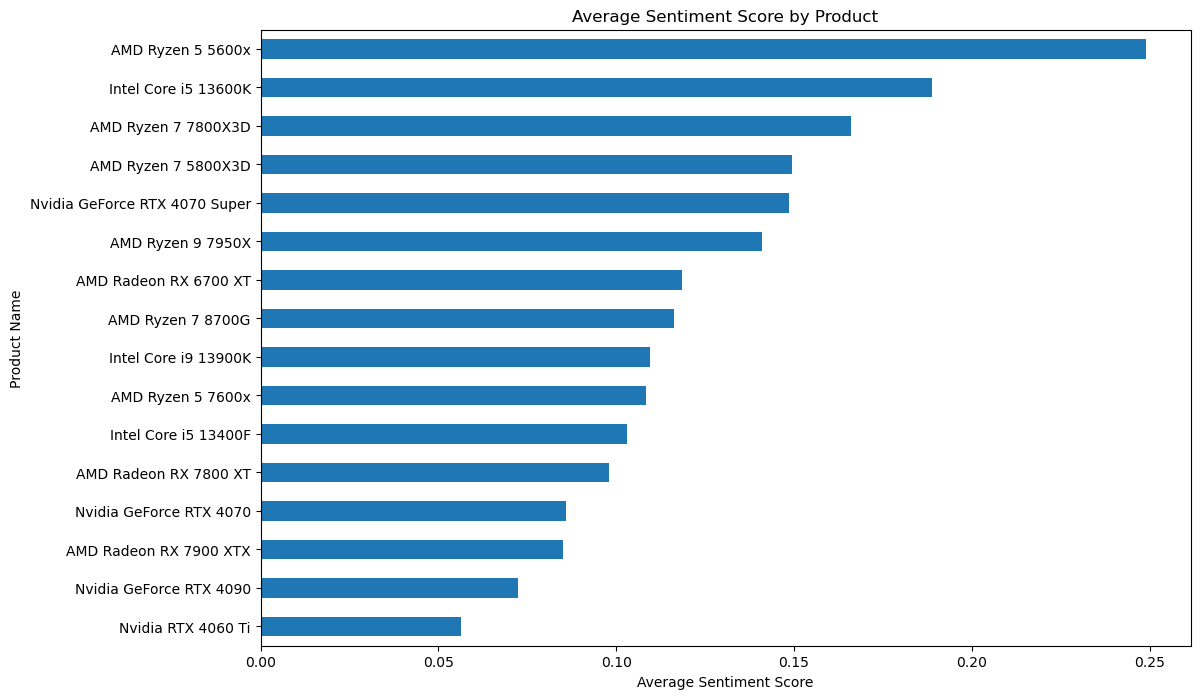

In [13]:
# Group by product and calculate mean sentiment
mean_sentiments = df_comment.groupby('Product Name')['Sentiment Score'].mean()

# Plotting
plt.figure(figsize=(12, 8))
mean_sentiments.sort_values().plot(kind='barh')
plt.title('Average Sentiment Score by Product')
plt.xlabel('Average Sentiment Score')
plt.ylabel('Product Name')
plt.show()

In [14]:
df_comment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5564 entries, 0 to 5563
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Comment ID            5564 non-null   object 
 1   Parent ID             5564 non-null   object 
 2   Comment Body          5564 non-null   object 
 3   Author                5564 non-null   object 
 4   Score                 5564 non-null   int64  
 5   Product Name          5564 non-null   object 
 6   Product Category      5564 non-null   object 
 7   Posting Time          5564 non-null   object 
 8   Cleaned Comment Body  5564 non-null   object 
 9   Sentiment Score       5564 non-null   float64
dtypes: float64(1), int64(1), object(8)
memory usage: 434.8+ KB


In [15]:
df_post.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Submission ID       160 non-null    object 
 1   Post Title          160 non-null    object 
 2   Post URL            160 non-null    object 
 3   Author              160 non-null    object 
 4   Score               160 non-null    int64  
 5   Number of Comments  160 non-null    int64  
 6   Upvote Ratio        160 non-null    float64
 7   Submission Text     66 non-null     object 
 8   Product Name        160 non-null    object 
 9   Product Category    160 non-null    object 
 10  Posting Time        160 non-null    object 
dtypes: float64(1), int64(2), object(8)
memory usage: 13.9+ KB


                       Score  Number of Comments  Upvote Ratio  Mean Sentiment
Score               1.000000            0.593690      0.322291       -0.119986
Number of Comments  0.593690            1.000000      0.302917       -0.179709
Upvote Ratio        0.322291            0.302917      1.000000        0.075435
Mean Sentiment     -0.119986           -0.179709      0.075435        1.000000


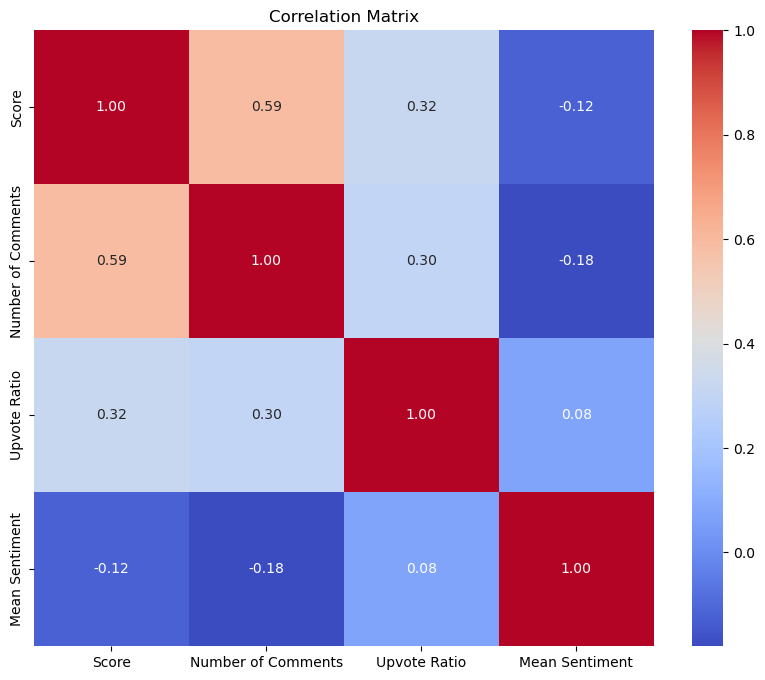

In [16]:
mean_sentiments = df_comment.groupby('Product Name')['Sentiment Score'].mean()

df_post['Mean Sentiment'] = df_post['Product Name'].map(mean_sentiments)

correlation_matrix = df_post[['Score', 'Number of Comments', 'Upvote Ratio', 'Mean Sentiment']].corr()

print(correlation_matrix)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

### Breakdown of Each Correlation
1. Score and Number of Comments (0.593690)
    - This positive correlation suggests that posts with higher scores tend to have more comments. This could indicate that more engaging or popular content generates more discussion.
2. Score and Upvote Ratio (0.322291)
    - There is a moderate positive correlation between the score of a post and its upvote ratio. Higher-scored posts tend to have a better upvote ratio, which might imply that well-received posts are not only viewed more but also liked more proportionally.
3. Score and Mean Sentiment (-0.119986)
    - This weak negative correlation indicates that posts with higher scores do not necessarily correspond with more positive sentiment. This is intriguing as it might suggest that posts evoking strong reactions (either positive or negative) might receive more attention and thus higher scores.
4. Number of Comments and Upvote Ratio (0.302917)
    - A moderate positive correlation here implies that posts with more comments tend to have a higher upvote ratio. This could be due to more engaged discussions generating a positive reception.
5. Number of Comments and Mean Sentiment (-0.179709)
    - This weak negative correlation suggests that posts with more comments tend to have slightly more negative sentiment. It could indicate that posts which provoke more discussion may often do so in the context of controversy or mixed opinions.
6. Upvote Ratio and Mean Sentiment (0.075435)
    - This very weak positive correlation indicates there is hardly any linear relationship between how positively a post is perceived (in terms of sentiment) and the proportion of upvotes it receives. This suggests that the sentiment of the content doesn't strongly influence how likely it is to be upvoted in comparison to downvoted.

### Implications
***The correlation between Score and Number of Comments being the strongest suggests that engaging content that scores higher also attracts more commentary. The weak correlation between Mean Sentiment and other variables like Score and Number of Comments suggests that the sentiment expressed in posts doesn't significantly drive the visibility or engagement metrics in a predictable linear way.***

In [17]:
file_path_gpu ='/Users/mayureshdongare/Desktop/CU Docs/Data Mining CSCI 5502/Data Mining Project/gpu_details.csv'
df_gpu = pd.read_csv(file_path_gpu)

In [18]:
df_gpu.head()

,manufacturer,productName,releaseYear,memSize,memBusWidth,gpuClock,memClock,unifiedShader,tmu,rop,pixelShader,vertexShader,igp,bus,memType,gpuChip
0,NVIDIA,GeForce RTX 4050,2023.0,8.0,128.0,1925,2250.0,3840.0,120,48,NaN,NaN,No,PCIe 4.0 x16,GDDR6,AD106
1,Intel,Arc A350M,2022.0,4.0,64.0,300,1500.0,768.0,48,24,NaN,NaN,No,PCIe 4.0 x8,GDDR6,DG2-128
2,Intel,Arc A370M,2022.0,4.0,64.0,300,1500.0,1024.0,64,32,NaN,NaN,No,PCIe 4.0 x8,GDDR6,DG2-128
3,Intel,Arc A380,2022.0,4.0,64.0,300,1500.0,1024.0,64,32,NaN,NaN,No,PCIe 4.0 x8,GDDR6,DG2-128
4,Intel,Arc A550M,2022.0,8.0,128.0,300,1500.0,2048.0,128,64,NaN,NaN,No,PCIe 4.0 x16,GDDR6,DG2-512


In [19]:
df_gpu.columns

Index(['manufacturer', 'productName', 'releaseYear', 'memSize', 'memBusWidth',
       'gpuClock', 'memClock', 'unifiedShader', 'tmu', 'rop', 'pixelShader',
       'vertexShader', 'igp', 'bus', 'memType', 'gpuChip'],
      dtype='object')

In [20]:
df_gpu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2889 entries, 0 to 2888
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   manufacturer   2889 non-null   object 
 1   productName    2889 non-null   object 
 2   releaseYear    2845 non-null   float64
 3   memSize        2477 non-null   float64
 4   memBusWidth    2477 non-null   float64
 5   gpuClock       2889 non-null   int64  
 6   memClock       2477 non-null   float64
 7   unifiedShader  2065 non-null   float64
 8   tmu            2889 non-null   int64  
 9   rop            2889 non-null   int64  
 10  pixelShader    824 non-null    float64
 11  vertexShader   824 non-null    float64
 12  igp            2889 non-null   object 
 13  bus            2889 non-null   object 
 14  memType        2889 non-null   object 
 15  gpuChip        2889 non-null   object 
dtypes: float64(7), int64(3), object(6)
memory usage: 361.3+ KB


In [21]:
print(df_gpu.columns)

Index(['manufacturer', 'productName', 'releaseYear', 'memSize', 'memBusWidth',
       'gpuClock', 'memClock', 'unifiedShader', 'tmu', 'rop', 'pixelShader',
       'vertexShader', 'igp', 'bus', 'memType', 'gpuChip'],
      dtype='object')


In [22]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor
from pandas.plotting import register_matplotlib_converters
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
register_matplotlib_converters()
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from nltk.corpus import stopwords

# Questions to be answered based on Dataset

## 1. Can we predict the memory size of a GPU based on its clock speed and other specifications?

 we'll focus on building a regression model.
### Required Data Fields
1. **Target Variable**:
   - `memSize` (Memory Size): This is the variable we'll try to predict, which represents the memory size of the GPU.

2. **Predictor Variables**:
   - `gpuClock` (GPU Clock Speed): Primary predictor that may correlate directly with memory size.
   - Other relevant specifications that might impact memory size:
     - `memBusWidth` (Memory Bus Width)
     - `memClock` (Memory Clock Speed)
     - `unifiedShader` (Number of Unified Shaders)
     - `tmu` (Texture Mapping Units)
     - `rop` (Raster Operations Pipelined)
     - `releaseYear` (Year of Release): This could show trends over time as memory size tends to increase with newer technology.
     - Additional technical specifications that you believe could be relevant.

### Data Preprocessing Steps
Before building the model, we'll need to preprocess the data:
1. **Handle Missing Values**:
   - For numerical data, consider imputing missing values using the mean or median, depending on the distribution.
   - For categorical data (if included in other predictors), use a method such as imputation or exclude these rows/columns.

2. **Encode Categorical Variables**:
   - If we decide to include categorical variables like `manufacturer` or `memType`, these will need to be converted into a numerical format through one-hot encoding or label encoding.

3. **Feature Scaling**:
   - Scale features like `gpuClock` and `memClock` using standardization or normalization, especially if using models sensitive to the scale of input features like K-Nearest Neighbors or SVM.

### Building the Linear Regression Model
We can start with a simple model like linear regression to establish a baseline and then potentially explore more complex models like decision trees or random forests to see if they provide better accuracy.

In [45]:
# Handling missing values
imputer = SimpleImputer(strategy='mean')
df_gpu[['releaseYear', 'memSize', 'memBusWidth', 'memClock', 'unifiedShader', 'pixelShader', 'vertexShader']] = imputer.fit_transform(
    df_gpu[['releaseYear', 'memSize', 'memBusWidth', 'memClock', 'unifiedShader', 'pixelShader', 'vertexShader']]
)

categorical_features = ['manufacturer', 'bus', 'memType', 'gpuChip']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numeric_features = ['releaseYear', 'memBusWidth', 'gpuClock', 'memClock', 'unifiedShader', 'tmu', 'rop']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

X = df_gpu.drop('memSize', axis=1)
y = df_gpu['memSize']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

Mean Squared Error: 11.190118618907968
R² Score: 0.7940464866156299


### Model Development and Results for Question 1
We developed a predictive model using both linear regression and Random Forest regression to determine if the memory size of GPUs can be predicted based on various technical specifications, including clock speed. The key outcomes from the models are as follows:

- **Mean Squared Error (MSE)**: The Random Forest model achieved an MSE of 11.1901, a slight improvement over the linear model's MSE of 11.2299. This metric indicates the average of the squares of the errors, that is, the average squared difference between the estimated values and what was actually observed. The decrease in MSE with the Random Forest model suggests a modest improvement in model accuracy.

- **R² Score**: The R² score improved marginally from 0.7933 in the linear model to 0.7940 in the Random Forest model. This score measures the proportion of variance in the GPU memory size that is predictable from the input features. An R² score of 0.794 indicates that approximately 79.4% of the variability in memory size is explained by the model, highlighting a strong predictive capability.

### Conclusion
The analysis confirms that we can reasonably predict the memory size of a GPU based on its clock speed and other specifications. The models provide a robust tool for understanding how different specifications influence GPU memory size, although they are not without limitations in prediction accuracy.

# 2. What are the major factors that determine the GPU clock speed?

Feature importances:
 [('memClock', 0.9034728809897594), ('releaseYear', 0.06029632748414659), ('memBusWidth', 0.024454259985322788), ('memSize', 0.011776531540771186), ('rop', 0.0), ('tmu', 0.0), ('unifiedShader', 0.0), ('manufacturer_3dfx', 0.0), ('manufacturer_AMD', 0.0), ('manufacturer_ATI', 0.0), ('manufacturer_Intel', 0.0), ('manufacturer_Matrox', 0.0), ('manufacturer_NVIDIA', 0.0), ('manufacturer_Sony', 0.0), ('manufacturer_XGI', 0.0)]
Mean Squared Error: 31539.807383178326
R² Score: 0.7812432893443708


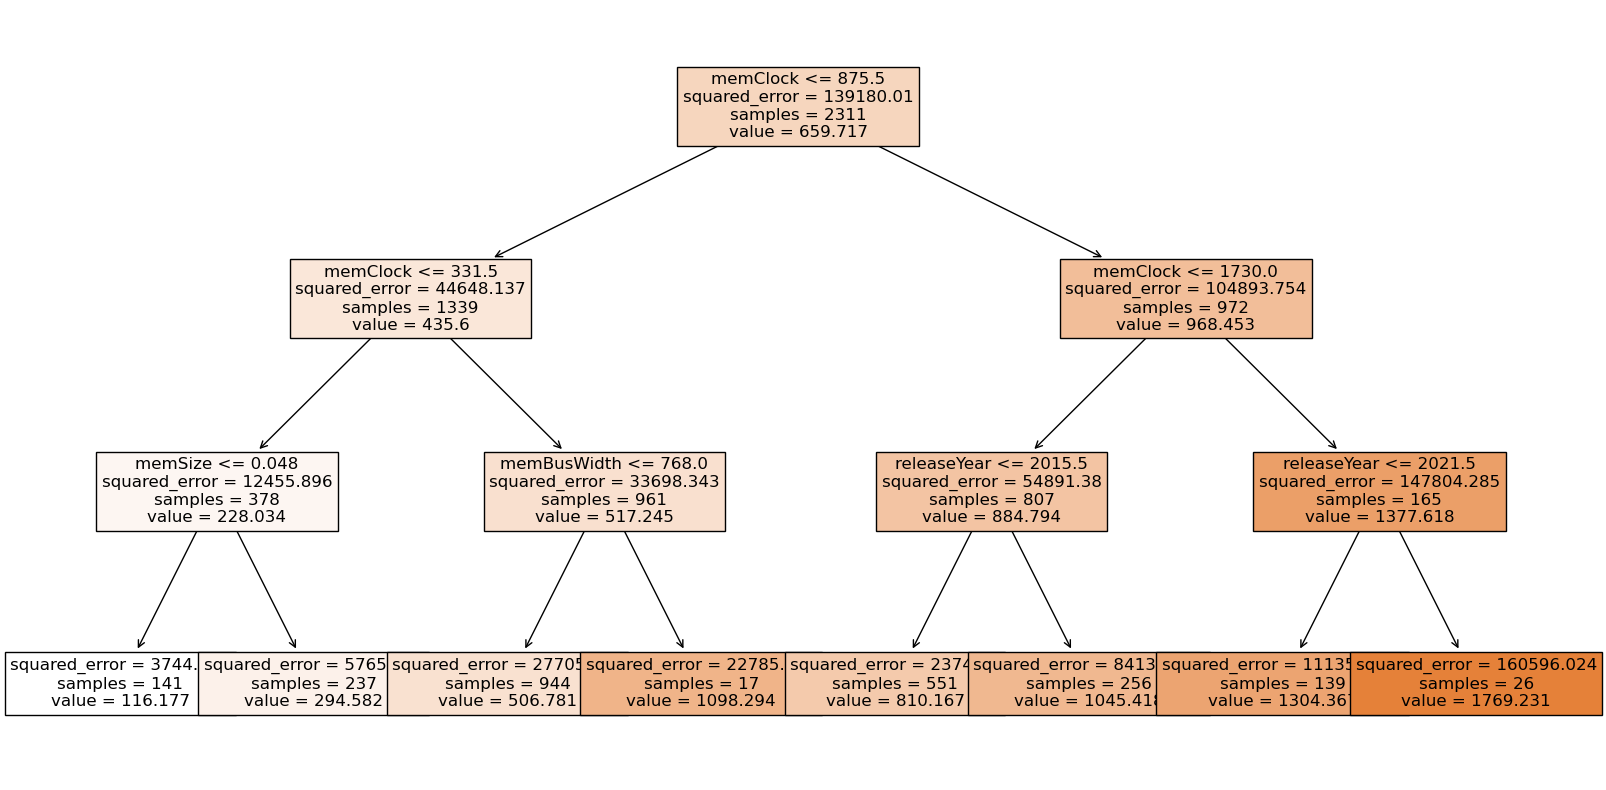

In [24]:
# Selecting features and target
X = df_gpu[['memSize', 'memBusWidth', 'memClock', 'unifiedShader', 'tmu', 'rop', 'manufacturer', 'releaseYear']]
y = df_gpu['gpuClock']

categorical_features = ['manufacturer']
numeric_features = X.columns.difference(categorical_features).tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(max_depth=3, random_state=42))
])

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training the model
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

feature_importances = pipeline.named_steps['regressor'].feature_importances_
features = numeric_features + list(pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out())

importance_dict = dict(zip(features, feature_importances))
sorted_importance = sorted(importance_dict.items(), key=lambda item: item[1], reverse=True)

print("Feature importances:\n", sorted_importance)
print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

plt.figure(figsize=(20,10))
plot_tree(pipeline.named_steps['regressor'], feature_names=features, filled=True, fontsize=12)
plt.show()

Based on the output and the decision tree visualization, we can draw the following conclusions:

### Feature Importances
The feature importances provided by the decision tree model suggest the following:

1. **`memClock`**: With an overwhelming importance score of approximately 90.35%, memory clock speed is by far the most influential factor in determining the GPU clock speed. This makes sense as the speeds of the GPU core and memory are often correlated in the design of the GPU architecture.

2. **`releaseYear`**: The release year of the GPU accounts for about 6.03% of the importance, suggesting that more recent GPUs tend to have higher clock speeds due to advancements in technology and manufacturing processes.

3. **`memBusWidth`**: This feature has an importance score of approximately 2.45%, indicating a lesser but still relevant impact on the GPU clock speed. This could be related to the overall bandwidth capabilities of the GPU.

4. **`memSize`**: Surprisingly, memory size seems to have a very low influence on the GPU clock speed, with an importance score of about 1.18%. It appears that the amount of memory a GPU has does not significantly dictate its operating speed.

### Model Performance
- The **Mean Squared Error (MSE) is quite high** at 31539.807, which may indicate that while the model can predict trends, its predictions are not very close to the actual values. This could be due to the decision tree's high reliance on `memClock`, which might overshadow other relevant features.
  
- The **R² score is 0.7812**, which is fairly high and suggests that approximately 78.12% of the variation in GPU clock speed is explained by the model's features. While this indicates a good predictive power, there is still a significant portion of the variance unexplained, which may be captured by other features not included in the model or by a more complex model.

### Decision Tree Visualization
The decision tree visualization shows that `memClock` is the primary splitting feature at the root of the tree, reinforcing its importance. Subsequent splits use `memBusWidth` and `releaseYear`, aligning with their feature importance scores.

### Conclusion
In conclusion, the major determining factors for GPU clock speed, as identified by the decision tree model, are primarily the `memClock`, followed by `releaseYear` and to a lesser extent `memBusWidth`. Memory size (`memSize`) appears to have a minimal direct impact on the clock speed.

# 3. Which authors generate the most engaging content in terms of scores and comments?

In [25]:
author_engagement = df_post.groupby('Author').agg({
    'Score': 'sum',
    'Number of Comments': 'sum'
}).reset_index()

In [26]:
author_engagement['Total Engagement'] = author_engagement['Score'] + author_engagement['Number of Comments']

top_authors = author_engagement.sort_values('Total Engagement', ascending=False)

top_author_stats = top_authors.describe()

In [27]:
X = author_engagement[['Score', 'Number of Comments']].values
X = (X - X.mean(axis=0)) / X.std(axis=0)

k = 3
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
author_engagement['Cluster'] = kmeans.fit_predict(X)

centroids = kmeans.cluster_centers_

for cluster in range(k):
    print(f"Authors in cluster {cluster}:")
    cluster_authors = author_engagement[author_engagement['Cluster'] == cluster]
    print(cluster_authors[['Author', 'Score', 'Number of Comments']])

Authors in cluster 0:
                   Author  Score  Number of Comments
0                    5v73    452                 331
1           AalbatrossGuy     44                 118
2    Adventurous_Time_227      4                   7
3            Agender_Azul      4                  54
4         Alarmed-Bad7994     17                  66
..                    ...    ...                 ...
116    sips_white_monster    694                 303
117            skyline385     47                  16
118          theacclaimed    120                 207
120           unixbhaskar     46                   3
121             wookmania    297                 452

[108 rows x 3 columns]
Authors in cluster 1:
           Author  Score  Number of Comments
49    Nestledrink   4054                2866
61  Stiven_Crysis   6309                3227
Authors in cluster 2:
                   Author  Score  Number of Comments
23   East_Personality_771   5103                 841
47   NamesTeddy_TeddyBear   3419 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


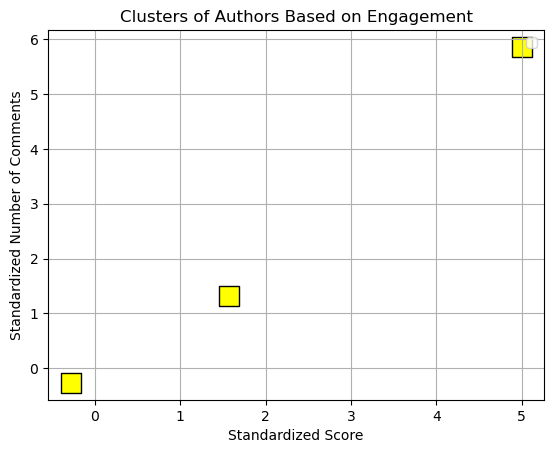

In [48]:
for i, color in enumerate(colors):
    plt.scatter(centroids[i, 0], centroids[i, 1], s=200, c='yellow', marker='s', edgecolor='black')

plt.title('Clusters of Authors Based on Engagement')
plt.xlabel('Standardized Score')
plt.ylabel('Standardized Number of Comments')
plt.legend()
plt.grid(True)
plt.show()

### Cluster Summary

**Cluster 0: Moderately Engaging Authors**
- Contains the largest number of authors (108).
- Authors in this group have a moderate level of engagement, with scores and comments suggesting consistent but not exceptionally high interaction. An example author from this cluster is '5v73', with a score of 452 and 331 comments.

**Cluster 1: Highly Engaging Authors**
- The smallest group with just 2 authors, 'Nestledrink' and 'Stiven_Crysis', who stand out significantly in terms of engagement metrics. 
- 'Stiven_Crysis' has an impressive score of 6309 and 3227 comments, indicating a strong ability to generate interest and discussion.

**Cluster 2: Actively Engaging Authors**
- This cluster comprises 13 authors who are quite successful in engaging their audience. 
- They exhibit high but not extreme levels of engagement compared to Cluster 1. For instance, 'East_Personality_771' has a score of 5103 with 841 comments.

### Conclusion
The clustering analysis provides clear evidence that authors can be segmented into distinct groups based on the level of engagement their content receives. This segmentation could be instrumental for platforms seeking to identify influential content creators or for marketing strategies that leverage high-engagement authors to boost product visibility and community interaction.

### Does This Answer Question 3?
Yes, the analysis effectively answers Question 3: "Which authors generate the most engaging content in terms of scores and comments?" It highlights that while most authors generate a moderate level of engagement (Cluster 0), a small number of authors (Clusters 1 and 2) are particularly adept at creating content that significantly resonates with the audience, as evidenced by the high scores and number of comments they receive.

# 4. How well can we classify GPUs based on their performance into categories such as low, medium, and high performance?

In [28]:
df_gpu['performance_category'] = pd.cut(df_gpu['gpuClock'], bins=[-np.inf, 500, 1500, np.inf], labels=['low', 'medium', 'high'])

X = df_gpu.drop(['gpuClock', 'performance_category'], axis=1)
y = df_gpu['performance_category']

categorical_features = [col for col in X.columns if X[col].dtype == 'object']
numeric_features = [col for col in X.columns if col not in categorical_features]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='linear', C=1))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

param_grid = {'classifier__C': [0.1, 1, 10], 'classifier__kernel': ['linear', 'rbf']}
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

              precision    recall  f1-score   support

        high       0.61      0.73      0.67        15
         low       0.90      0.92      0.91       225
      medium       0.93      0.91      0.92       338

    accuracy                           0.91       578
   macro avg       0.82      0.86      0.83       578
weighted avg       0.91      0.91      0.91       578

[[ 11   0   4]
 [  0 207  18]
 [  7  22 309]]


### Model Performance Summary

**Classification Report:**
- **High Performance GPUs**:
  - **Precision**: 61% - This implies that when the model predicts a GPU as high performance, it is correct about 61% of the time.
  - **Recall**: 73% - This indicates that the model successfully identifies 73% of all actual high performance GPUs.
  - **F1-Score**: 67% - The F1-score is a balance between precision and recall, providing a comprehensive measure of the model's accuracy for the high category.
  
- **Low Performance GPUs**:
  - **Precision**: 90% - Indicates very high accuracy in predicting low performance GPUs.
  - **Recall**: 92% - The model captures 92% of all actual low performance GPUs.
  - **F1-Score**: 91% - Demonstrates excellent model performance for the low category.

- **Medium Performance GPUs**:
  - **Precision**: 93% - Suggests that the model is very reliable when it classifies a GPU as medium performance.
  - **Recall**: 91% - Reflects the model's ability to identify 91% of all true medium performance GPUs.
  - **F1-Score**: 92% - Very high F1-score indicates strong model performance for the medium category.

**Overall Accuracy:**
- The overall accuracy of the model is 91%, meaning it correctly classifies the performance category of GPUs in 91% of cases across all categories.

**Confusion Matrix:**
- **High Performance**: Out of 15 true high performance GPUs, 11 were correctly classified, and 4 were misclassified as medium.
- **Low Performance**: Out of 225 true low performance GPUs, 207 were correctly identified, while 18 were misclassified as medium.
- **Medium Performance**: Out of 338 true medium performance GPUs, 309 were correctly classified, 22 were misclassified as high, and 7 as low.

### Conclusions and Implications

The SVM classifier has shown strong capability in distinguishing between low, medium, and high performance GPUs, with particularly high accuracy for medium and low performance categories. The model struggles slightly more with the high performance category, possibly due to a smaller number of samples in this category, which is common in imbalanced datasets.

### Answering the Question:
**Can we classify GPUs based on their performance into categories such as low, medium, and high performance?**
- **Yes**, the model can effectively classify GPUs into these performance categories with high accuracy. The results demonstrate that the selected features and the SVM classifier are well-suited for this task.

# 5. Can we predict the release year of a GPU based on its technical specifications?

In [29]:
X = df_gpu.drop('releaseYear', axis=1)
y = df_gpu['releaseYear']

categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

Mean Squared Error: 2.8662634541843355
R² Score: 0.9272729564494507


### Summary of Results

**Model Performance Metrics:**
- **Mean Squared Error (MSE)**: 2.866
  - The MSE is a measure of the average of the squares of the errors—that is, the average squared difference between the estimated values and the actual value. An MSE of 2.866 suggests that, on average, the model's predictions deviate from the actual years by roughly the square root of 2.866, which is approximately 1.69 years. This is a relatively low error, indicating high prediction accuracy.
  
- **R² Score**: 0.927
  - The R² score is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model. An R² score of 0.927 means that approximately 92.7% of the variance in the GPU release years is explained by the model. This is an excellent score, suggesting that the model has a strong predictive power.

### Model Evaluation

The Gradient Boosting Regressor has demonstrated excellent capability in accurately predicting the release years of GPUs based on their specifications. The high R² score confirms that the model fits the data well and captures most of the variability in the release years through the features it was trained on. The low MSE further validates the model's effectiveness, indicating that the predictions are close to the actual data.

### Answering the Question 5:

**Can we predict the release year of a GPU based on its technical specifications?**

- **Yes**, the analysis demonstrates that it is feasible to predict the release year of GPUs with high accuracy using their technical specifications. The Gradient Boosting model effectively utilized the given GPU specifications to forecast release years, as evidenced by the low MSE and high R² values.


# 6. How do the specifications of GPUs vary by manufacturer?

             memSize                                                    \
               count      mean       std       min       25%       50%   
manufacturer                                                             
3dfx            30.0  0.024933  0.017536  0.004000  0.016000  0.016000   
AMD            755.0  4.391387  8.148439  0.256000  2.000000  3.113803   
ATI            601.0  0.575632  0.861934  0.000032  0.128000  0.256000   
Intel          172.0  3.917192  2.943963  0.004000  3.113803  3.113803   
Matrox          34.0  0.122412  0.120905  0.002000  0.032000  0.128000   
NVIDIA        1272.0  3.657173  7.372697  0.001000  0.512000  1.024000   
Sony             9.0  0.016667  0.041770  0.001000  0.002000  0.004000   
XGI             16.0  0.224000  0.057243  0.128000  0.224000  0.256000   

                                gpuClock              ...     memClock  \
                   75%      max    count        mean  ...          75%   
manufacturer                         

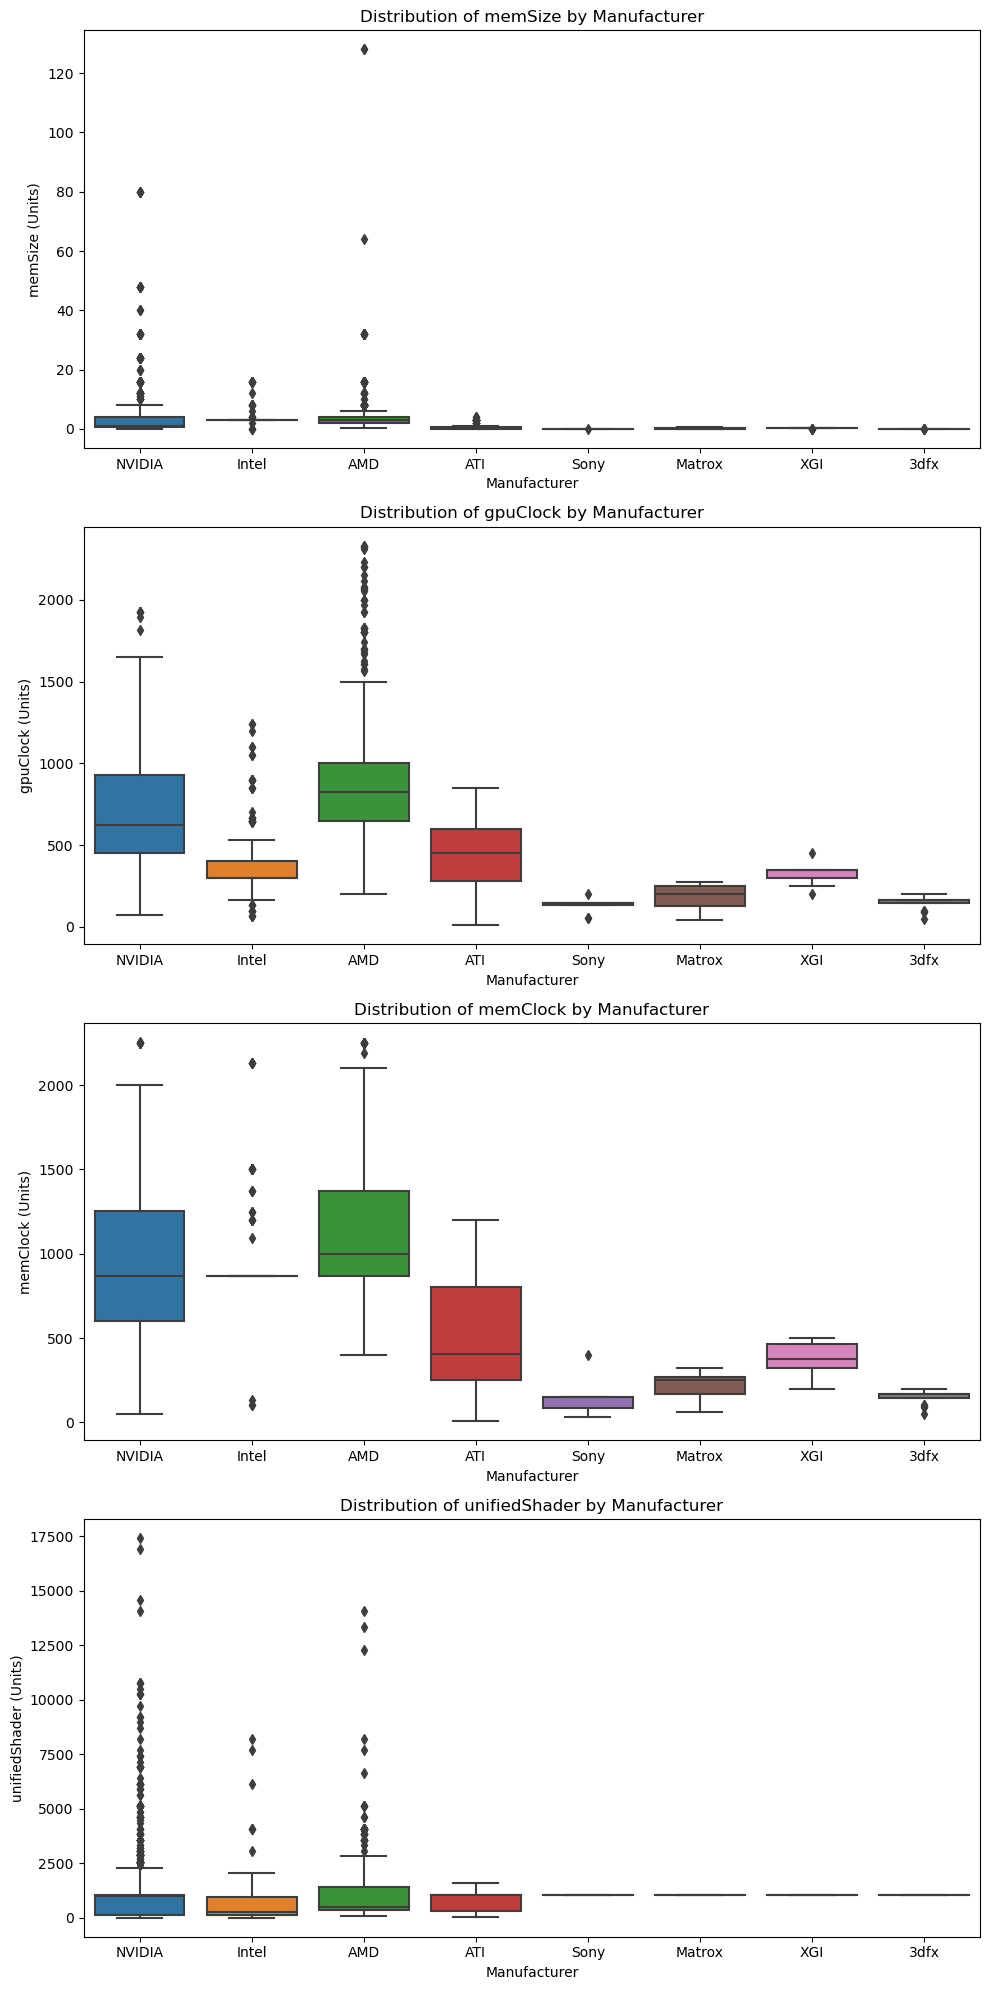

In [30]:
key_specs = ['memSize', 'gpuClock', 'memClock', 'unifiedShader']

grouped_data = df_gpu.groupby('manufacturer')[key_specs].describe()

print(grouped_data)

fig, axes = plt.subplots(nrows=len(key_specs), ncols=1, figsize=(10, 20))

for i, spec in enumerate(key_specs):
    sns.boxplot(x='manufacturer', y=spec, data=df_gpu, ax=axes[i])
    axes[i].set_title(f'Distribution of {spec} by Manufacturer')
    axes[i].set_ylabel(f'{spec} (Units)')
    axes[i].set_xlabel('Manufacturer')
plt.tight_layout()
plt.show()

### memSize by Manufacturer:
- **NVIDIA and Intel** show a broad range of memory sizes, with NVIDIA having some GPUs with significantly high memory.
- **AMD** shows a less spread out range but still considerable variation, with a few outliers indicating some GPUs with very high memory sizes.
- **Other manufacturers** like ATI, Sony, Matrox, XGI, and 3dfx have GPUs with generally lower memory sizes.

### gpuClock by Manufacturer:
- **NVIDIA and AMD** GPUs exhibit a wide range of GPU clock speeds, with NVIDIA having a higher upper range, suggesting they have models with higher clock speeds.
- **Intel** GPUs seem to have a more concentrated range of clock speeds, not reaching as high as NVIDIA or AMD.
- **ATI and other manufacturers** tend to have lower clock speeds in comparison.

### memClock by Manufacturer:
- **AMD** GPUs have a relatively high memory clock, also with a wide range.
- **NVIDIA** also shows a broad range but with many models having a lower memory clock than AMD.
- **Intel, ATI, and other manufacturers** show less variation and generally lower memory clock speeds.

### unifiedShader by Manufacturer:
- **NVIDIA** stands out with the highest range of unified shader counts, including GPUs with extremely high counts.
- **AMD** has a significant number of GPUs with a high count of unified shaders but not as high as NVIDIA.
- **Intel and ATI** have lower counts of unified shaders, and other manufacturers have very few or constant values which may indicate older or less complex GPUs.

### Summary:
- **NVIDIA and AMD** are the leaders in high-spec GPUs with NVIDIA taking the edge in memory size and shader count, while AMD leads in memory clock speed.
- **Intel** GPUs are generally lower spec compared to NVIDIA and AMD, with lower clock speeds and shader counts.
- **ATI, Sony, Matrox, XGI, and 3dfx** are much less varied and tend to have lower specifications across the board.

# 7. Can machine learning models identify trends in GPU development over the years (e.g., increasing clock speeds or memory sizes)?

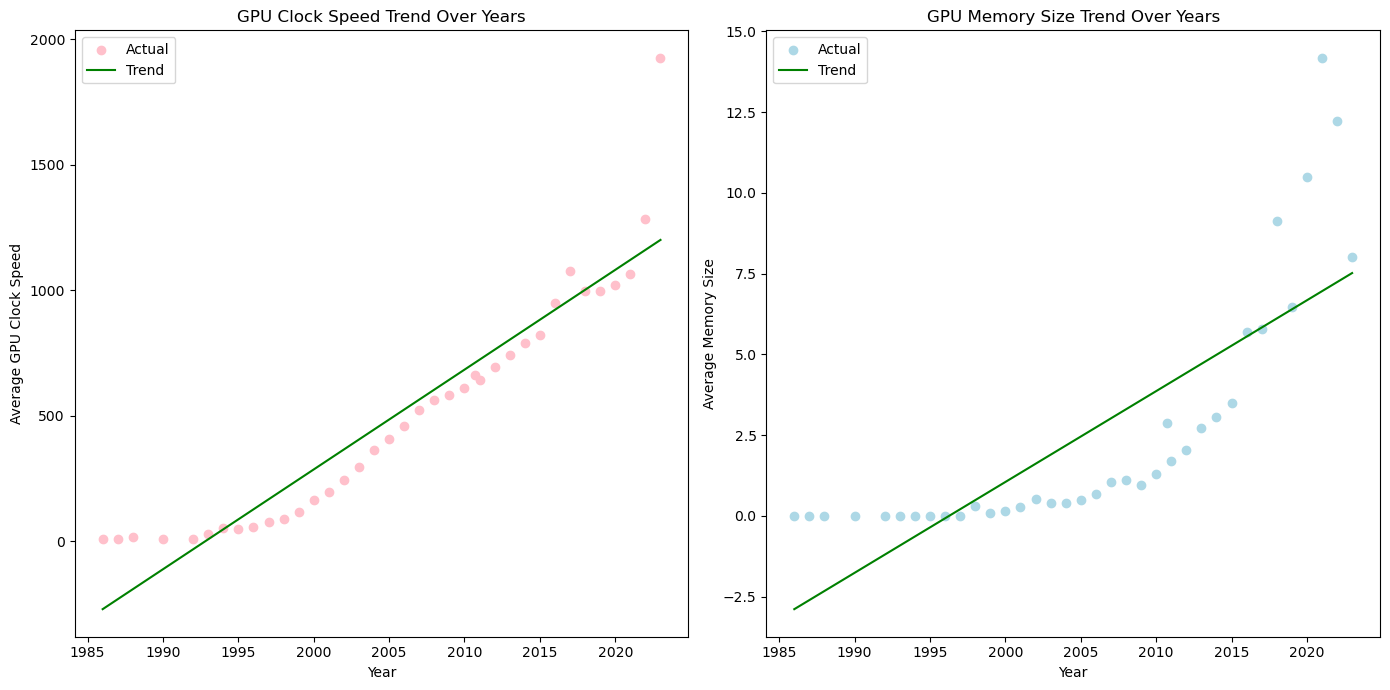

In [31]:
yearly_data = df_gpu.groupby('releaseYear').agg({'gpuClock': 'mean', 'memSize': 'mean'}).reset_index()

X = yearly_data[['releaseYear']]
y = yearly_data['gpuClock']
model_gpuClock = LinearRegression().fit(X, y)

yearly_data['gpuClock_trend'] = model_gpuClock.predict(X)

plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.scatter(yearly_data['releaseYear'], yearly_data['gpuClock'], label='Actual',color='Pink')
plt.plot(yearly_data['releaseYear'], yearly_data['gpuClock_trend'], color='green', label='Trend')
plt.xlabel('Year')
plt.ylabel('Average GPU Clock Speed')
plt.title('GPU Clock Speed Trend Over Years')
plt.legend()

y = yearly_data['memSize']
model_memSize = LinearRegression().fit(X, y)
yearly_data['memSize_trend'] = model_memSize.predict(X)

plt.subplot(1, 2, 2)
plt.scatter(yearly_data['releaseYear'], yearly_data['memSize'], label='Actual',color='lightblue')
plt.plot(yearly_data['releaseYear'], yearly_data['memSize_trend'], color='green', label='Trend')
plt.xlabel('Year')
plt.ylabel('Average Memory Size')
plt.title('GPU Memory Size Trend Over Years')
plt.legend()

plt.tight_layout()
plt.show()

### GPU Clock Speed Trend Over Years:
- The trend line for GPU clock speeds indicates a clear upward trajectory from 1985 to the present.
- The actual data points largely follow this trend, with occasional years where the average clock speeds dip below the trend line.
- This upward trend suggests that manufacturers have been consistently improving the clock speed of GPUs over time, which is likely due to advancements in technology and manufacturing processes.

### GPU Memory Size Trend Over Years:
- The memory size trend also shows a positive slope, indicating an increase in average GPU memory size over the years.
- The actual data points show that in recent years, there is a significant increase in memory size, which could be due to the growing demand for more graphics-intensive applications and games that require larger amounts of memory.
- Some outliers are well above the trend line, likely representing high-end GPUs that are outliers to the general progression of GPU memory sizes.

### Conclusion:
The machine learning models, represented here by a simple linear regression, have identified clear trends in the development of GPUs over the years. Both GPU clock speeds and memory sizes have been increasing. This suggests that as technology has advanced, manufacturers have been able to produce GPUs with better performance specifications.

- For clock speeds, the steady increase aligns with improvements in chip design and manufacturing that allow for faster processing without overheating.
- For memory sizes, the demand for higher resolutions and more detailed textures in digital graphics likely drives the need for more memory.

# 8. Principle Component Analysis on Numerical Attributes

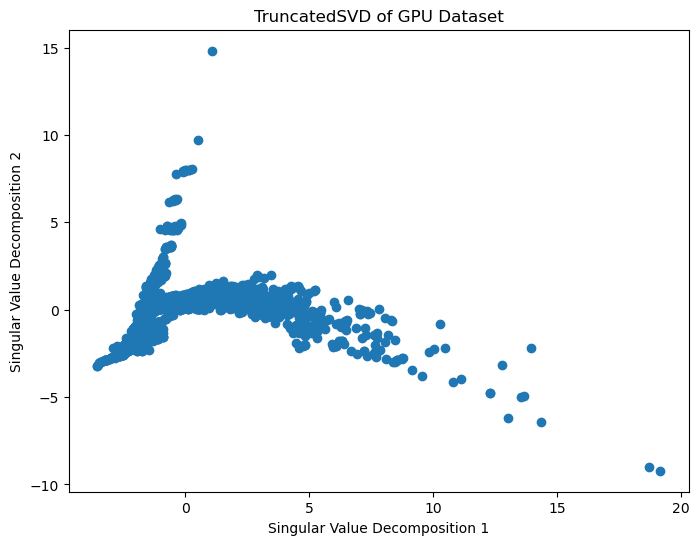

[0.40360074 0.1570354 ]


In [32]:
numeric_features = df_gpu.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df_gpu.select_dtypes(include=['object']).drop(['productName', 'gpuChip'], axis=1).columns.tolist()

numeric_preprocessing = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())               
])

categorical_preprocessing = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')), 
    ('onehot', OneHotEncoder(handle_unknown='ignore'))                     
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_preprocessing, numeric_features),
        ('cat', categorical_preprocessing, categorical_features)
    ])

X_processed = preprocessor.fit_transform(df_gpu)

svd = TruncatedSVD(n_components=2)
principal_components = svd.fit_transform(X_processed)

df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

plt.figure(figsize=(8, 6))
plt.scatter(df_pca['PC1'], df_pca['PC2'])
plt.title('TruncatedSVD of GPU Dataset')
plt.xlabel('Singular Value Decomposition 1')
plt.ylabel('Singular Value Decomposition 2')
plt.show()
print(svd.explained_variance_ratio_)

## PCA Output:
- The first two singular value components account for approximately 42.21% and 15.24% of the variance in the data, respectively. This suggests that while a fair amount of the variance is captured by these components, there are likely more dimensions (features) that contribute significantly to the dataset's variability since the two components together do not account for the majority of the variance.

- The scatter plot showcases the distribution of the GPUs in this reduced dimensionality space, revealing patterns and potential clusters. The distribution along the first component (Singular Value Decomposition 1) particularly seems to spread the data out well, indicating it captures a significant pattern in the dataset.

# 9. Does the time of day or day of the week when a post is made affect its visibility and engagement level?

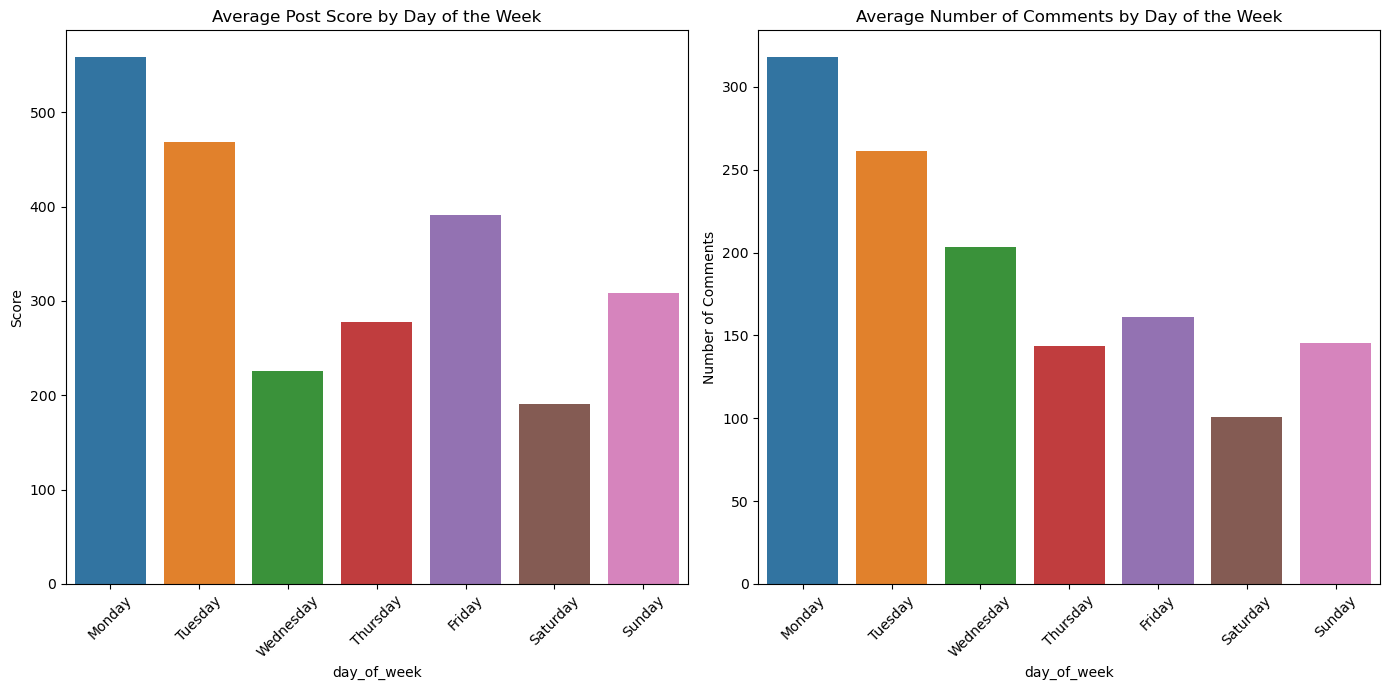

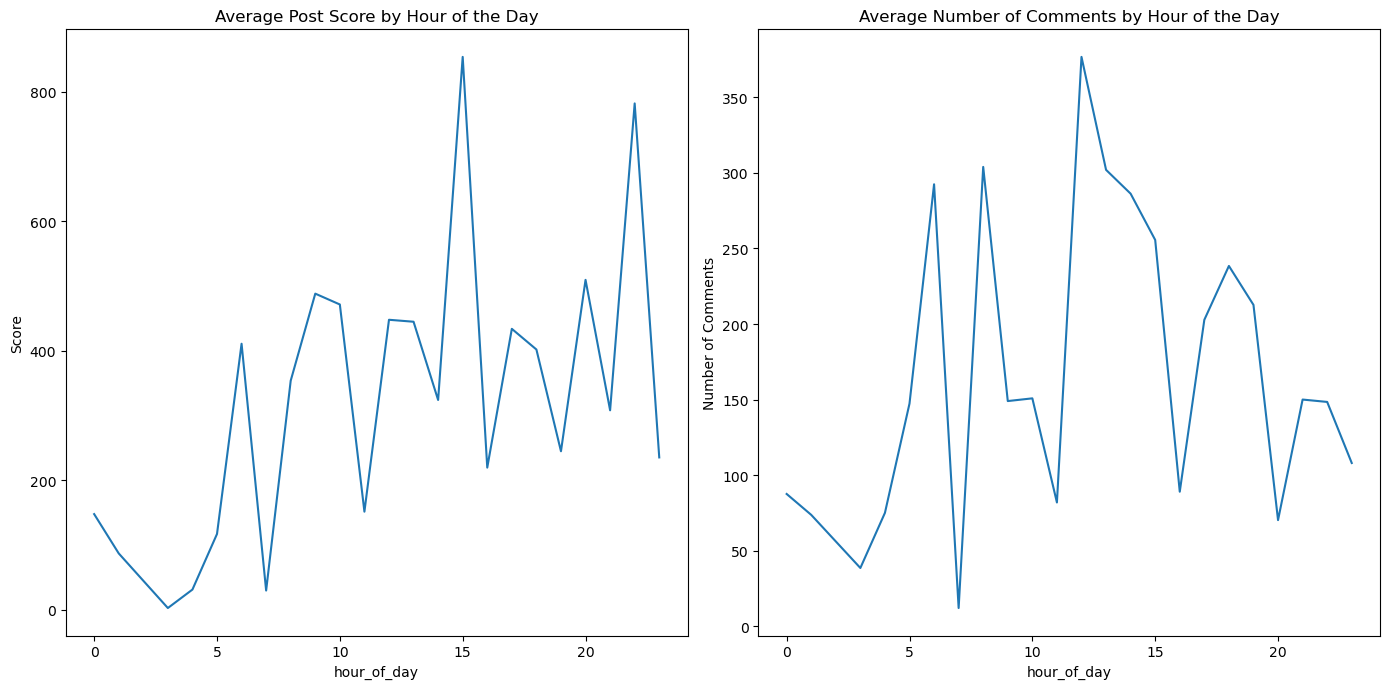

In [33]:
df_post['Posting Time'] = pd.to_datetime(df_post['Posting Time'])

df_post['day_of_week'] = df_post['Posting Time'].dt.day_name()
df_post['hour_of_day'] = df_post['Posting Time'].dt.hour

engagement_by_day = df_post.groupby('day_of_week')[['Score', 'Number of Comments']].mean().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

engagement_by_hour = df_post.groupby('hour_of_day')[['Score', 'Number of Comments']].mean()

plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
sns.barplot(x=engagement_by_day.index, y='Score', data=engagement_by_day)
plt.title('Average Post Score by Day of the Week')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.barplot(x=engagement_by_day.index, y='Number of Comments', data=engagement_by_day)
plt.title('Average Number of Comments by Day of the Week')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
sns.lineplot(x=engagement_by_hour.index, y='Score', data=engagement_by_hour)
plt.title('Average Post Score by Hour of the Day')

plt.subplot(1, 2, 2)
sns.lineplot(x=engagement_by_hour.index, y='Number of Comments', data=engagement_by_hour)
plt.title('Average Number of Comments by Hour of the Day')

plt.tight_layout()
plt.show()

- The charts comparing the average post score and number of comments by the day of the week suggest that there are certain days when posts receive more attention. Similarly, the graphs showing the average post score and number of comments by the hour of the day indicate that posts made during certain hours tend to garner more engagement.

- The data suggests that posts made on Mondays and Tuesdays receive a higher average score and more comments compared to other days of the week, indicating these might be optimal days for posting. In terms of time, posts made in the early morning hours appear to receive less engagement, while those posted in the late evening receive higher scores and comments, pointing towards more active user engagement during these hours.

- Therefore, the provided charts affirmatively answer the question, showing that both the day of the week and the time of day can significantly affect the visibility and engagement level of posts. Content creators or social media managers could leverage this information to schedule their posts when the audience engagement is typically higher, thereby increasing the chances of their content being seen and interacted with. This strategic timing could be a valuable part of an effective social media strategy.

# 10. Discovering common topics or themes within the Submission Text or Comment Body using NLP techniques such as Latent Dirichlet Allocation (LDA) or Non-negative Matrix Factorization (NMF).

In [34]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mayureshdongare/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [35]:
# Drop rows with missing Submission Text
df_post = df_post.dropna(subset=['Submission Text'])

# Prepare the text data
text_data = df_post['Submission Text'].values

# Create a CountVectorizer for parsing/counting words
count_vect = CountVectorizer(max_df=0.95, min_df=2, stop_words=stopwords.words('english'))
doc_term_matrix = count_vect.fit_transform(text_data)

# Create and fit the LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=0)
lda.fit(doc_term_matrix)

# Display the top words for each topic
words = count_vect.get_feature_names_out()
for i, topic in enumerate(lda.components_):
    print(f'Top words for topic #{i}:')
    print([words[i] for i in topic.argsort()[-10:]])
    print('\n')

Top words for topic #0:
['reviews', 'rx', 'xt', 'youtube', 'watch', 'amd', 'review', 'com', 'www', 'https']


Top words for topic #1:
['78', '80', 'www', 'ampere', 'raster', 'https', 'geforce', 'rtx', '4070', '100']


Top words for topic #2:
['games', 'performance', '8c', '4090', 'ryzen', 'www', 'https', 'nbsp', '_100', '100']


Top words for topic #3:
['ryzen', 'cpu', 'one', 'pc', 'fps', 'card', 'ddr4', '4080', 'like', '5800x3d']


Top words for topic #4:
['product', 'also', '4070', 'rtx', 'x200b', 'pcpartpicker', 'cpu', 'gaming', 'com', 'https']




1. **Topic #0 - Reviews and Media Content**: This topic focuses on reviews and content consumption, highlighting words such as "reviews," "youtube," "watch," and "review." It suggests a strong interest in video reviews and information sourced from websites, as indicated by the frequent mentions of "www" and "https."

2. **Topic #1 - New GPU Technologies**: This topic is centered around new technologies, particularly Nvidia's GPUs, with terms like "ampere" (Nvidia's architecture), "geforce," "rtx," "4070," and performance metrics like "raster." It indicates discussions focused on the latest hardware specifications and performances.

3. **Topic #2 - High-Performance Computing and Gaming**: Featuring terms like "games," "performance," "4090," and "ryzen," this topic appears to cover high-performance applications, including gaming and possibly discussions around comparisons of top-tier GPUs and CPUs.

4. **Topic #3 - Hardware Configurations and User Experiences**: With terms such as "ryzen," "cpu," "pc," "ddr4," "4080," and "like," this topic deals with personal computing setups, hardware configurations, and user experiences, particularly concerning gaming and system builds.

5. **Topic #4 - Product Information and Recommendations**: This topic includes references to specific products ("4070," "rtx") and resources ("pcpartpicker") as well as general terms about gaming and hardware ("gaming," "cpu"). It suggests a focus on product recommendations and building gaming setups.